##### Set up packages and directories

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML

In [2]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
cryptic_input_path = "D:/Project_Data/CRYPTIC_DATA/"
output_dir = project_dir + '/Output'
refseq_dir = 'D:/NCBI_Dataset_Mycobacteria'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16

##### Translation function

In [3]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]

In [4]:
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [5]:
def translate_orf(start, end, strand):
    return translate_sequence(full_sequence[start:end], strand, 0)              

##### Output nt sequences in FASTA format

In [6]:
def produce_nt_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

##### Mycobrowser is used for CDS demarcation, sequence is taken from GCF_000195955.2

In [113]:
tb_cds_dict = {}
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq
actual_cds_boundaries = []
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
#  temp = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand']]      #Just CDS
temp = mycobrowser_df[['Locus','Start','Stop','Strand']]     #All features
actual_cds_boundaries = []
for i, r in temp.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_cds_boundaries.append((r['Locus'],r['Start']-1, r['Stop'], strand))
    tb_cds_dict[r['Locus']] = (r['Start']-1, r['Stop'], strand)

##### Load variant dataset and create variant dictionary (0 indexed for genome position - whereas CRyPtiC data uses 1 start)

In [114]:
variant_count_df = pd.read_csv(cryptic_output_path + '/filtered_variant_summary_df.csv')
variant_count_df = variant_count_df[variant_count_df['MUTATION_PCT'] < 0.1]

In [115]:
temp = variant_count_df.groupby(['GENOME_INDEX'])[['MYKROBE_LINEAGE_NAME_2']].count().reset_index()
temp_dict = dict(zip(temp.GENOME_INDEX, temp.MYKROBE_LINEAGE_NAME_2))

In [116]:
mutation_counts_dict = {}
for i in tqdm(range(len(full_sequence))):
    if (i+1) in temp_dict:
        mutation_counts_dict[i] = temp_dict[(i+1)]
    else:
        mutation_counts_dict[i] = 0

  0%|          | 0/4411532 [00:00<?, ?it/s]

##### Define binomial probabilities for testing mutation counts

In [117]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [118]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for j in range(mutation_counts_dict[i]):
            mutations.append(i)
    bin_counts = [0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (2)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)))  

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than defined p-value

In [119]:
def max_orf(seq_start, seq_stop, p_value, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for i in range(seq_len - 2):
            orf_length = 0
            test_codon = temp[i: i+3] 
            if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                for j in range(i + 3, seq_len - 2, 3):
                    test_codon_2 = temp[j: j+3] 
                    if test_codon_2 in ['TAG','TGA','TAA']:
                        orf_length = j - i
                        break
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    prob = mutation_bin_probability(orf_start, orf_end, orf_strand)
                    if prob < p_value and orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length, prob))
                    
                if orf_length > max_len and prob< p_value and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 
    
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len, mutation_bin_probability(start_pos, end_pos, strand))   

In [120]:
def filter_orf_list(orfs):
    filtered_list = []
    #Find largest and add
    to_remove = [1,2]
    iter = 0
    while len(orfs) > 0:
        to_remove = []
        max_len = 0
        max_pos = 0
        for i, orf in enumerate(orfs):
            if orf[3] > max_len:
                max_pos = i
                max_len = orf[3]
        filtered_list.append(orfs[max_pos])
        for i, orf in enumerate(orfs):
            if orf[2] == orfs[max_pos][2] and orf[0]%3 == orfs[max_pos][0]%3 and not(orf[1] <orfs[max_pos][0] or orf[0] >= orfs[max_pos][1]):
                to_remove.append(orf)
        if len(to_remove) > 0:
            for orf in to_remove:
                orfs.remove(orf)
    return filtered_list

##### Graph p-values for annotated genes

In [126]:
annotated_cds_probabilities = []
for (locus, start, stop, strand) in tqdm(actual_cds_boundaries):
    annotated_cds_probabilities.append((locus, mutation_bin_probability(start, stop, strand)))

  0%|          | 0/4187 [00:00<?, ?it/s]

Text(0, 0.5, 'number of genes - Mycobrowser R3 annotation')

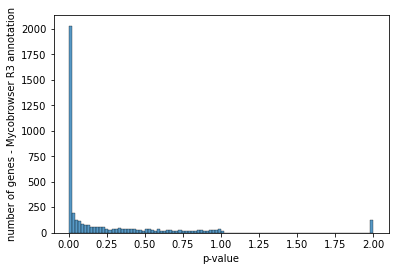

In [127]:
annotation_probs = [x[1] for x in annotated_cds_probabilities]
sns.histplot(annotation_probs, bins = 100)
plt.xlabel("p-value")
plt.ylabel("number of genes - Mycobrowser R3 annotation") 

##### Identify function percentage in Unknown between high and low p-value regions

In [128]:
locus_info_dict = {}
for i, r in mycobrowser_df.iterrows():
    if r['Feature'] == 'CDS':
        locus_info_dict[r['Locus']] = r['Function']

In [129]:
locus_exceptions = [x[0] for x in annotated_cds_probabilities if (x[1] > 0.5 and x[1] < 1.1)]
num_unknown_exceptions = 0
for ex in locus_exceptions:
    if ex in locus_info_dict:
        if 'nknown' in locus_info_dict[ex]:
            num_unknown_exceptions += 1
tot_locus = [x[0] for x in annotated_cds_probabilities]
num_unknown_tot = 0
for ex in tot_locus:
    if ex in locus_info_dict:
        if len(str(locus_info_dict[ex])) > 4:
            if 'nknown' in locus_info_dict[ex]:
                num_unknown_tot += 1
print(num_unknown_exceptions, len(locus_exceptions))
print(num_unknown_tot, len(tot_locus))
print(num_unknown_exceptions/len(locus_exceptions), (num_unknown_tot-num_unknown_exceptions)/(len(tot_locus)-len(locus_exceptions)))

378 618
2313 4187
0.6116504854368932 0.5421686746987951


##### Percentage of nt mutated by each CDS

<AxesSubplot:ylabel='Count'>

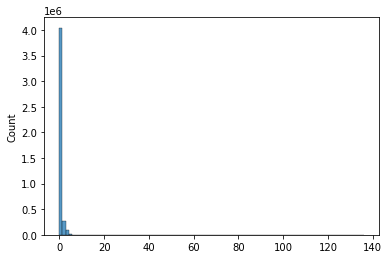

In [130]:
num_mutations = []
for k, v in mutation_counts_dict.items():
    num_mutations.append(v)
sns.histplot(num_mutations, bins=100)

  0%|          | 0/4187 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Pct_Mutation', ylabel='Count'>

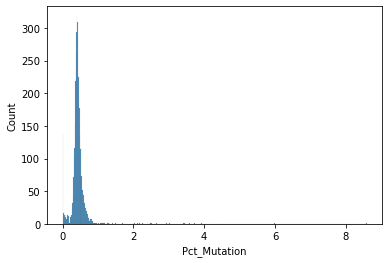

In [131]:
cds_mutation_percentage = []
for (locus, start, stop, strand) in tqdm(actual_cds_boundaries):
    num_mutations = 0
    for i in range(start,stop):
        num_mutations += (mutation_counts_dict[i])
    cds_mutation_percentage.append([locus, num_mutations / (stop - start)])
temp = pd.DataFrame(cds_mutation_percentage)
temp.columns = ['Locus', 'Pct_Mutation']
sns.histplot(temp['Pct_Mutation'])

##### Take intergenic regions and find maximal ORFs in all frames

In [151]:
putative_protein_dict = {}
putative_proteins = []
non_included_boundaries = []
for i, (locus,start,stop,strand) in enumerate(actual_cds_boundaries):
    if i==0 or stop >= actual_cds_boundaries[i-1][2]:
        non_included_boundaries.append(actual_cds_boundaries[i])
for i, (locus,start,stop,strand) in enumerate(non_included_boundaries):
        if i < len(non_included_boundaries) - 1:
            orf_details_list = max_orf(stop, non_included_boundaries[i+1][1], 3, output_all_orfs = True, min_orf_length = 200)
            filtered_orf_details_list = filter_orf_list(orf_details_list)
            if len(filtered_orf_details_list) > 0:
                last_locus = 'A'
                locus_suffix = 0
                for orf_details in filtered_orf_details_list:
                    a = translate_orf(orf_details[0], orf_details[1], orf_details[2])
                    
                    if locus == last_locus:
                        locus_suffix +=1
                    else:
                        locus_suffix = 0
                    last_locus = locus
                   # print(locus+'_'+str(locus_suffix), orf_details)
                    putative_proteins.append([locus+'_'+str(locus_suffix), a[:-1]])
                    putative_protein_dict[locus+'_'+str(locus_suffix)] = orf_details
produce_nt_blast_file(putative_proteins, refseq_dir + '/putative_protein.faa')

  0%|          | 0/423 [00:00<?, ?it/s]

In [161]:
w_d = os.getcwd()
os.chdir("D:/")
#subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\putative_protein.faa -db myco_refseq_nt -out tblastn_testresults.xml -evalue 0.001 -outfmt 5 -num_threads 16', shell=True, capture_output = True)      #-seg=no 
subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\putative_protein.faa -db myco_refseq_nt -out tblastn_testresults.xml -evalue 0.001 -seg=no  -outfmt 10 -num_threads 16', shell=True, capture_output = True)      #-seg=no 
os.chdir(w_d)

In [162]:
nick = pd.read_csv("D:\\BLAST\\myco_refseq_nt\\tblastn_testresults.xml", header = None)

In [163]:
nick.columns = ['qaccver', 'saccver', 'pident','length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
nick = nick[nick.pident>50]
nick['info']=  nick['qaccver'].map(putative_protein_dict)
nick[['start_coord', 'end_coord', 'strand', 'q_length', 'prob']] = pd.DataFrame(nick['info'].tolist(), index=nick.index)
nick.to_csv(project_dir + '/temp.csv')

In [155]:
putative_protein_dict['Rv0912_0']

(1016819, 1017215, -1, 393, 0.853331685760283)

In [40]:
blast_results_list = []
result_handle = open("D:\\BLAST\\myco_refseq_nt\\tblastn_testresults.xml")
blast_records = NCBIXML.parse(result_handle)
for blast_record in blast_records:
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            blast_results_list.append([blast_record.query, alignment.title, alignment.accession, alignment.length, hsp.expect, hsp.identities, hsp.query_start, hsp.query_end, hsp.sbjct_start, hsp.sbjct_end, hsp.strand, hsp.score])

In [43]:
blast_results_df = pd.DataFrame(blast_results_list, columns = ['query', 'title', 'accession', 'length', 'e_value', 'identities', 'query_start', 'query_end', 'subject_start','subject_end','subject_strand', 'score'])

In [52]:
blast_results_df.to_csv(project_dir + '/temp2.csv')

In [45]:
print(len(putative_proteins))

72


In [49]:
temp = blast_results_df[blast_results_df.e_value < 1e-5]
pd.DataFrame(temp.groupby('query').count()).to_csv(project_dir + '/temp.csv')

In [112]:
coverage_df = pd.read_csv(project_dir + '/coverage.csv')

In [101]:
low_coverage_genes = []
for i, r in coverage_df.iterrows():
    if r['cover'] < 3:
        low_coverage_genes.append(r['locus_tag'])

In [ ]:
#locus_exceptions = [x[0] for x in annotated_cds_probabilities if (x[1][0] > 0.5 and x[1][0] < 1.1)]
#for l in locus_exceptions:
for l in low_coverage_genes:
    if l in tb_cds_dict:
        (start, end, strand) = tb_cds_dict[l]
        print (l, start, end, strand)
        alt_orfs = max_orf(start - 80, end + 80, 3 , output_all_orfs = True, min_orf_length = int(0.75 * (end-start)))
        if len(alt_orfs) > 0:
            for orf in alt_orfs:
                    if orf[2] != strand or (orf[1] - start)%3 != 0:
                        print(orf)

In [80]:
produce_nt_blast_file(record, refseq_dir + '/putative_protein.faa')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
##### Now start off with lower than 0.5 p-values in set and add maximal ORF sets with p-values < 0.1

In [84]:
p_value = 0.1
num_iterations = 0

#cds_boundaries = [[0, 0], [4411530, 4411530]]      #De novo
#cds_dict = {}
#for i in cds_boundaries:
#    cds_dict[tuple(i)] = 1
    
    
cds_boundaries = []
cds_dict = {}
for (locus, x, y, strand) in actual_cds_boundaries:
    if mutation_bin_probability(x, y, strand)[0] <= 0.2:
        cds_dict[(x,y)] = strand
        cds_boundaries.append([x, y])
    
exhausted_cds = []
while len(exhausted_cds) < len(cds_boundaries) - 1:
    temp_boundaries = []
    for i, (x,y) in enumerate((cds_boundaries)):
        if i < len(cds_boundaries) - 1:
            if [x,y] in exhausted_cds:
                pass
            else:
                temp = cds_boundaries[i+1][0]
                res = max_orf(y, temp, p_value)
                if (res[1] - res[0] < 100):
                    exhausted_cds.append([x,y])
                else:
                    temp_boundaries.append([res[0], res[1]])
                    cds_dict[(res[0],res[1])] = res[2]
                
    cds_boundaries = sorted(cds_boundaries + temp_boundaries, key=lambda x: x[0])
    print("iteration " + str(num_iterations) + ":  "+str(len(cds_boundaries))+ " found.  "+str(len(exhausted_cds))+" exhausted regions")
    num_iterations += 1

iteration 0:  3446 found.  2265 exhausted regions
iteration 1:  3776 found.  3115 exhausted regions
iteration 2:  3905 found.  3646 exhausted regions
iteration 3:  3939 found.  3870 exhausted regions
iteration 4:  3952 found.  3925 exhausted regions
iteration 5:  3956 found.  3947 exhausted regions
iteration 6:  3957 found.  3954 exhausted regions
iteration 7:  3959 found.  3954 exhausted regions
iteration 8:  3959 found.  3958 exhausted regions


In [ ]:
def max_overlap(boundary, comparison_boundaries):
    max_overlap = 0
    comparison_boundary_0 = 0
    comparison_boundary_1 = 0
    locus = ''
    strand = 1
    for bound in comparison_boundaries:
        overlap = min(boundary[1], bound[2]) - max(boundary[0], bound[1])
        if overlap > max_overlap:
            max_overlap = overlap
            comparison_boundary_0 = bound[1]
            comparison_boundary_1 = bound[2]
            locus = bound[0]
            strand = bound[3]
    return(locus, strand, comparison_boundary_0, comparison_boundary_1, max_overlap)

In [ ]:
temp = []
for bound in tqdm(cds_boundaries):
    a = max_overlap(bound, actual_cds_boundaries)
    if a[3] > 0:
        temp.append([a[0],a[1],a[2],a[3],a[4], cds_dict[(bound[0],bound[1])], bound[0], bound[1], bound[0]-a[2], bound[1]-a[3]])
df = pd.DataFrame(temp, columns = ['locus','annotation_strand','annotation_start','annotation_end', 'overlap', 'simulated_strand','simulated_start', 'simulated_end', 'start_offset','end_offset'])

In [136]:
seq_data = sar.Ortholog_Sequence_Dataset(orthologs, genome_datasets_dir, genome_ids, 50, tb_species) 

100%|██████████| 16/16 [00:00<00:00, 38.42it/s]


In [85]:
out_list = []
for i in actual_cds_boundaries:
    temp = mutation_bin_probability(i[1],i[2],i[3])
    if (temp[0] > 0.9 and temp[0] < 1.1) :
        new_temp = (max_orf(i[1]-100,i[2]+100, 0.1))
        if new_temp[1] - new_temp[0] > 300:
            print(i, temp)
            print(new_temp, mutation_bin_probability(new_temp[0],new_temp[1],new_temp[2]))
            print('*****************************************')

('Rv0140', 166909, 167290, 1) (0.9458959406553689, 172, [71, 53, 48])
(166927, 167242, -1, (0.002688750782290694, 140, [34, 43, 63])) (0.002688750782290694, 140, [34, 43, 63])
*****************************************
('Rv0314c', 382878, 383541, -1) (0.9649303018285086, 294, [107, 103, 84])
(382935, 383463, 1, (0.043717054988640314, 237, [64, 81, 92])) (0.043717054988640314, 237, [64, 81, 92])
*****************************************
('Rv0493c', 583700, 584690, -1) (0.9868156502819309, 458, [167, 160, 131])
(583963, 584710, 1, (0.06920547246692332, 352, [125, 96, 131])) (0.06920547246692332, 352, [125, 96, 131])
*****************************************
('Rv0544c', 635934, 636213, -1) (0.9094443155189642, 131, [45, 49, 37])
(635986, 636310, -1, (0.0656515400376283, 152, [42, 50, 60])) (0.0656515400376283, 152, [42, 50, 60])
*****************************************
('Rv0628c', 718760, 719912, -1) (1.0, 3, [1, 2, 0])
(718675, 719068, -1, (0.07942376793913364, 45, [12, 13, 20])) (0.0794

In [ ]:
out_list = []
for i in actual_cds_boundaries:
    
    if mutation_bin_probability(i[1],i[2],i[3])[0] > 0.3:
        
        temp = df[df['locus'] == i[0]]
        if len(temp)== 1:
            alt_len = temp.iloc[0]['simulated_end'] - temp.iloc[0]['simulated_start']
            if mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand'])[0]<0.1 and alt_len > 500 :
                print(temp.iloc[0]['locus'], i[2]-i[1])
                print ([i[1],i[2],i[3]],mutation_bin_probability(i[1],i[2],i[3]))
                print ("alternative", str(alt_len))
                print([temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']], mutation_bin_probability(temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']))
                out_list.append([temp.iloc[0]['locus'], temp.iloc[0]['annotation_start'], temp.iloc[0]['annotation_end'], temp.iloc[0]['annotation_strand'], temp.iloc[0]['simulated_start'],temp.iloc[0]['simulated_end'],temp.iloc[0]['simulated_strand']])
                if temp.iloc[0]['simulated_strand'] == 1:
                    print(translate_sequence((full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
                else:
                    print(translate_sequence(align.reverse_complement(full_sequence[temp.iloc[0]['simulated_start']: temp.iloc[0]['simulated_end']])))
tempdf = pd.DataFrame(out_list, columns = ['locus','annotation_start','annotation_end', 'annotation_strand', 'simulated_start', 'simulated_end', 'simulated_strand'])      
tempdf.to_csv(cryptic_output_path + '/nick2.csv')